In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

import sys
print(sys.version)
print( "numpy :", np.__version__ )
print( "sklearn: ", sklearn.__version__)

3.9.17 (main, Jul  5 2023, 20:47:11) [MSC v.1916 64 bit (AMD64)]
numpy : 1.23.5
sklearn:  1.3.0


# EO PRODUCTION

In [16]:
df = pd.read_excel('ÜRETİM_TÜKETİM_DEĞERLERİ2023.xlsx')
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df = df.iloc[:144,:]
df["Water"] = ((df["Selektivite"].apply(lambda x: 100-x)/100) * df["Etilen"]/28.05) * 2 * 18.01528
df = df[["MEG(FQ581)","DEG(FQ582)","Water","Etilen","Selektivite","EO Üretim(ton)","Oksijen(ton)"]]
df = df.astype(float)
df

,MEG(FQ581),DEG(FQ582),Water,Etilen,Selektivite,EO Üretim(ton),Oksijen(ton)
1,50.00,1.61,24.867213,124.31,84.426619,164.815675,126.346484
2,210.00,16.00,30.206151,152.02,84.531204,201.804493,154.056181
3,230.00,23.38,33.418586,169.07,84.611958,224.652545,170.944466
4,261.87,26.37,32.908119,169.95,84.925471,226.658589,170.311891
5,269.03,27.01,32.151061,168.51,85.146408,225.322757,167.805108
...,...,...,...,...,...,...,...
140,269.42,25.86,33.158546,168.80,84.707274,224.546452,170.211774
141,267.52,26.33,32.827556,165.57,84.564569,219.878688,167.629836
142,240.70,26.22,27.888742,147.00,85.230240,196.754237,146.032992
143,220.18,25.98,24.687349,127.70,84.949691,170.359262,127.883555


In [17]:
X = df[["Etilen","Oksijen(ton)","Selektivite"]]
y = df["EO Üretim(ton)"]

polynomial_converter = PolynomialFeatures(degree=3,include_bias=False)

poly_features = polynomial_converter.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.33, random_state=101)



from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

model.fit(X_train,y_train)

EO_test_predictions = model.predict(X_test)


from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE = mean_absolute_error(y_test, EO_test_predictions)
MSE = mean_squared_error(y_test, EO_test_predictions)
RMSE = np.sqrt(MSE)


display(RMSE)

4.731026676892749e-14

(0.0, 1e-05)

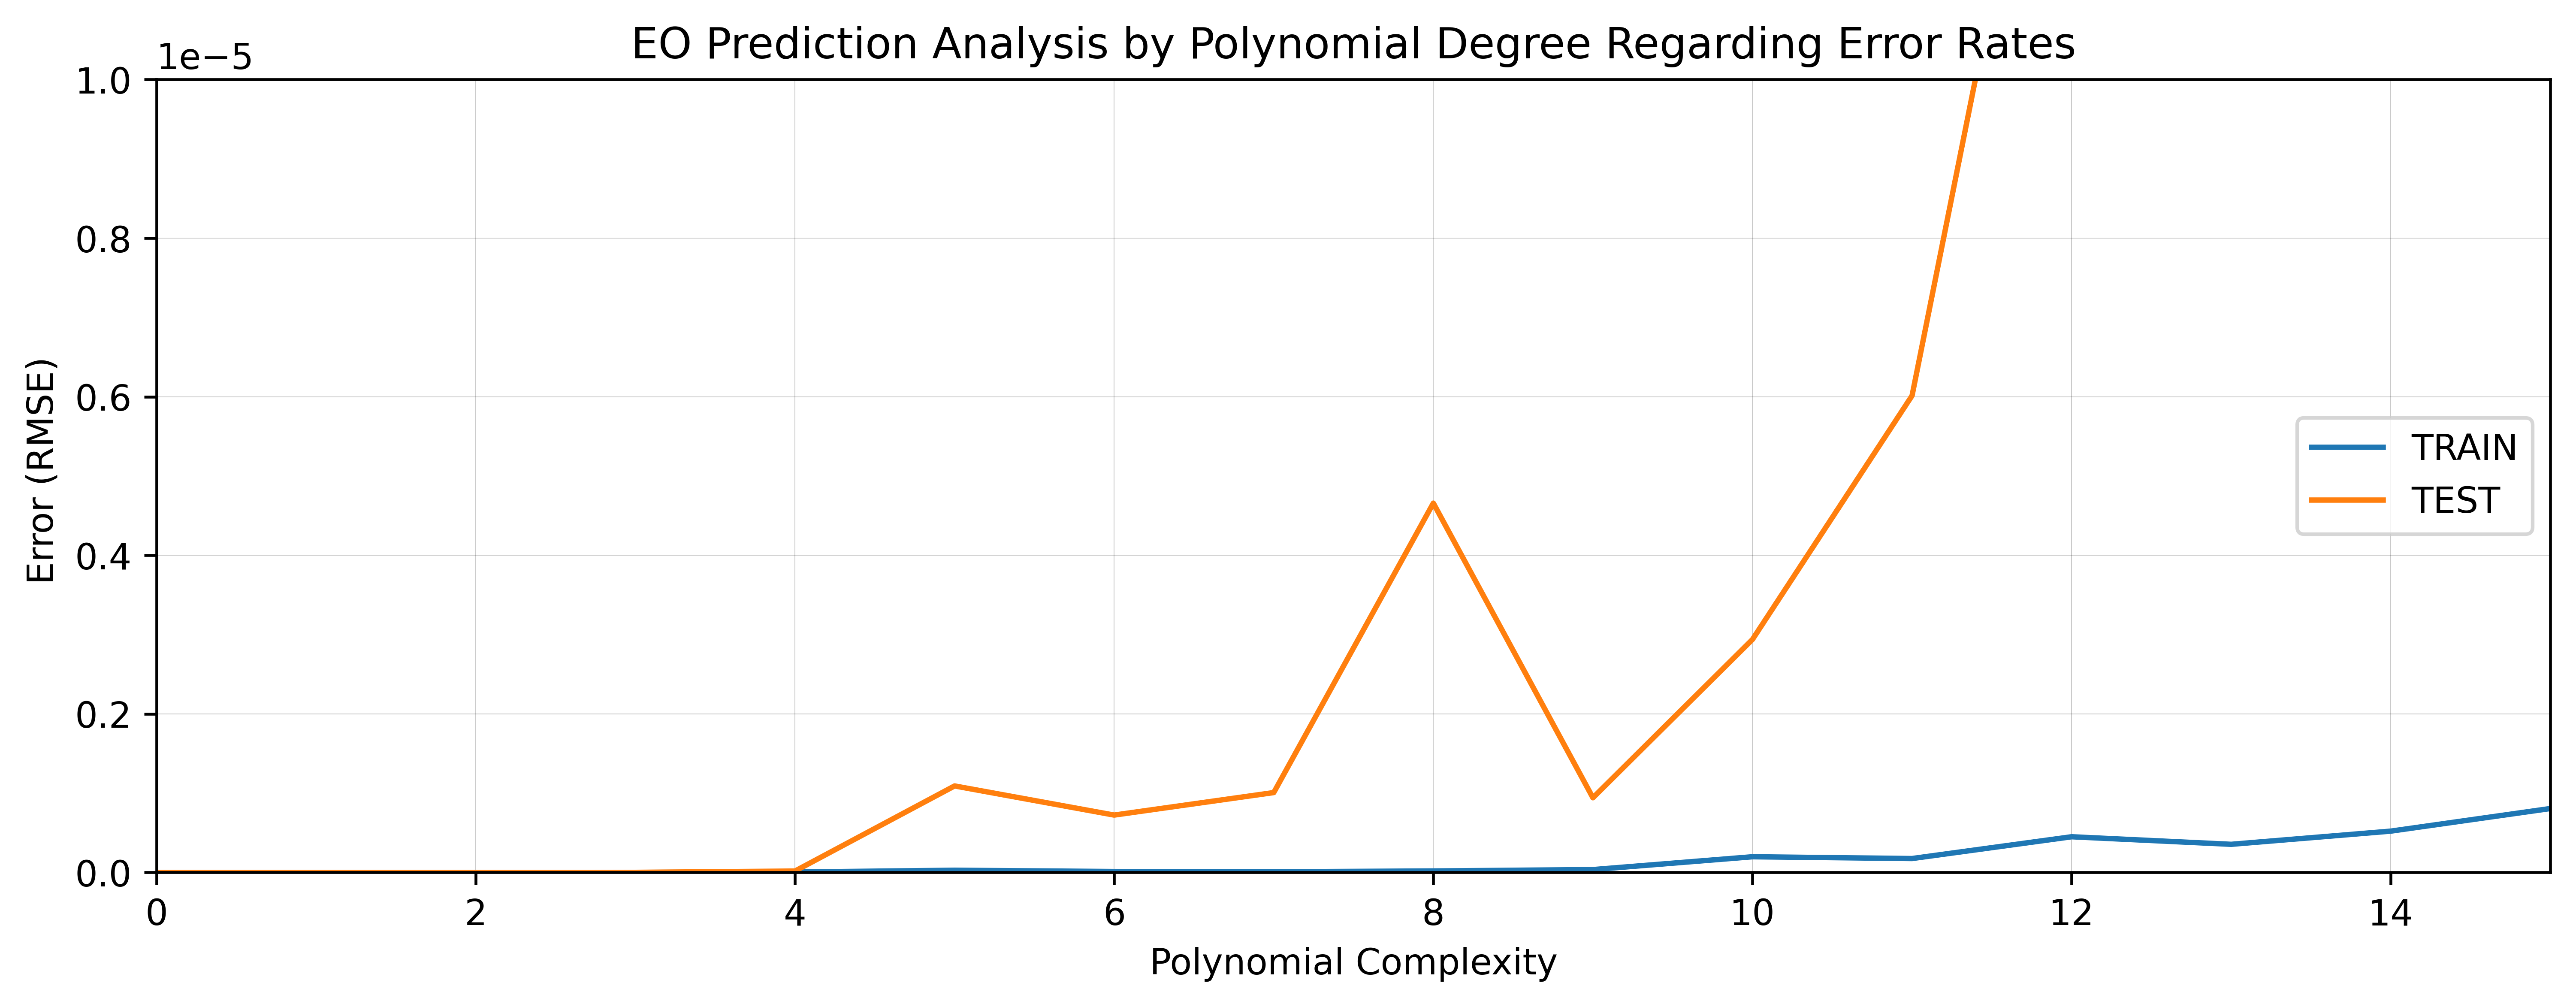

In [18]:
train_rmse_errors = []
test_rmse_errors = []

for d in range(1,20):
    
    polynomial_converter = PolynomialFeatures(degree=d, include_bias=False)
    poly_features = polynomial_converter.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=101)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train,y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_RMSE = np.sqrt(mean_squared_error(y_train,train_pred))
    test_RMSE = np.sqrt(mean_squared_error(y_test,test_pred))
    
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)


plt.figure(figsize=(12,4))

plt.plot(range(0,len(train_rmse_errors)),train_rmse_errors[:],label='TRAIN')
plt.plot(range(0,len(test_rmse_errors)),test_rmse_errors[:],label='TEST')

plt.rcParams['figure.dpi'] = 600

plt.grid(color='black', linestyle='-', linewidth=0.05)

plt.xlabel("Polynomial Complexity")
plt.ylabel(" Error (RMSE)")

plt.legend(loc="center right", fontsize=10)

plt.title("EO Prediction Analysis by Polynomial Degree Regarding Error Rates")
plt.xlim(0,15)
plt.ylim(0,10**-5)

In [19]:
final_poly_converter = PolynomialFeatures(degree=3, include_bias=True)

final_model = LinearRegression()

fully_converted_X = final_poly_converter.fit_transform(X)
final_model.fit(fully_converted_X, y)


from joblib import dump, load

dump(final_model, 'EO_model.joblib')
dump(final_poly_converter, 'EO_converter.joblib')

loaded_converter_EO = load('EO_converter.joblib')
loaded_model_EO = load('EO_model.joblib')


def EO_prod(Etilen, Oksijen, Selektivite):
    
    loaded_data_EO = [np.array([Etilen, Oksijen, Selektivite])]
    
    transformed_data_EO = loaded_converter_EO.fit_transform(loaded_data_EO)
    
    result_EO = loaded_model_EO.predict(transformed_data_EO)
    
    return result_EO[0]

# MEG PRODUCTION

In [20]:
X = df[["EO Üretim(ton)", "Water"]]
X = X[5:]

y = df[["MEG(FQ581)"]]
y = y[5:]

polynomial_converter = PolynomialFeatures(degree=2 ,include_bias=False)

poly_features = polynomial_converter.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=101)


from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

model.fit(X_train,y_train)

MEG_test_predictions = model.predict(X_test)


from sklearn.metrics import mean_absolute_error, mean_squared_error

MSE = mean_squared_error(y_test, MEG_test_predictions)
RMSE = np.sqrt(MSE)


display(RMSE)

4.736655522489582

Text(0.5, 1.0, 'MEG Prediction Analysis by Polynomial Degree Regarding Error Rates')

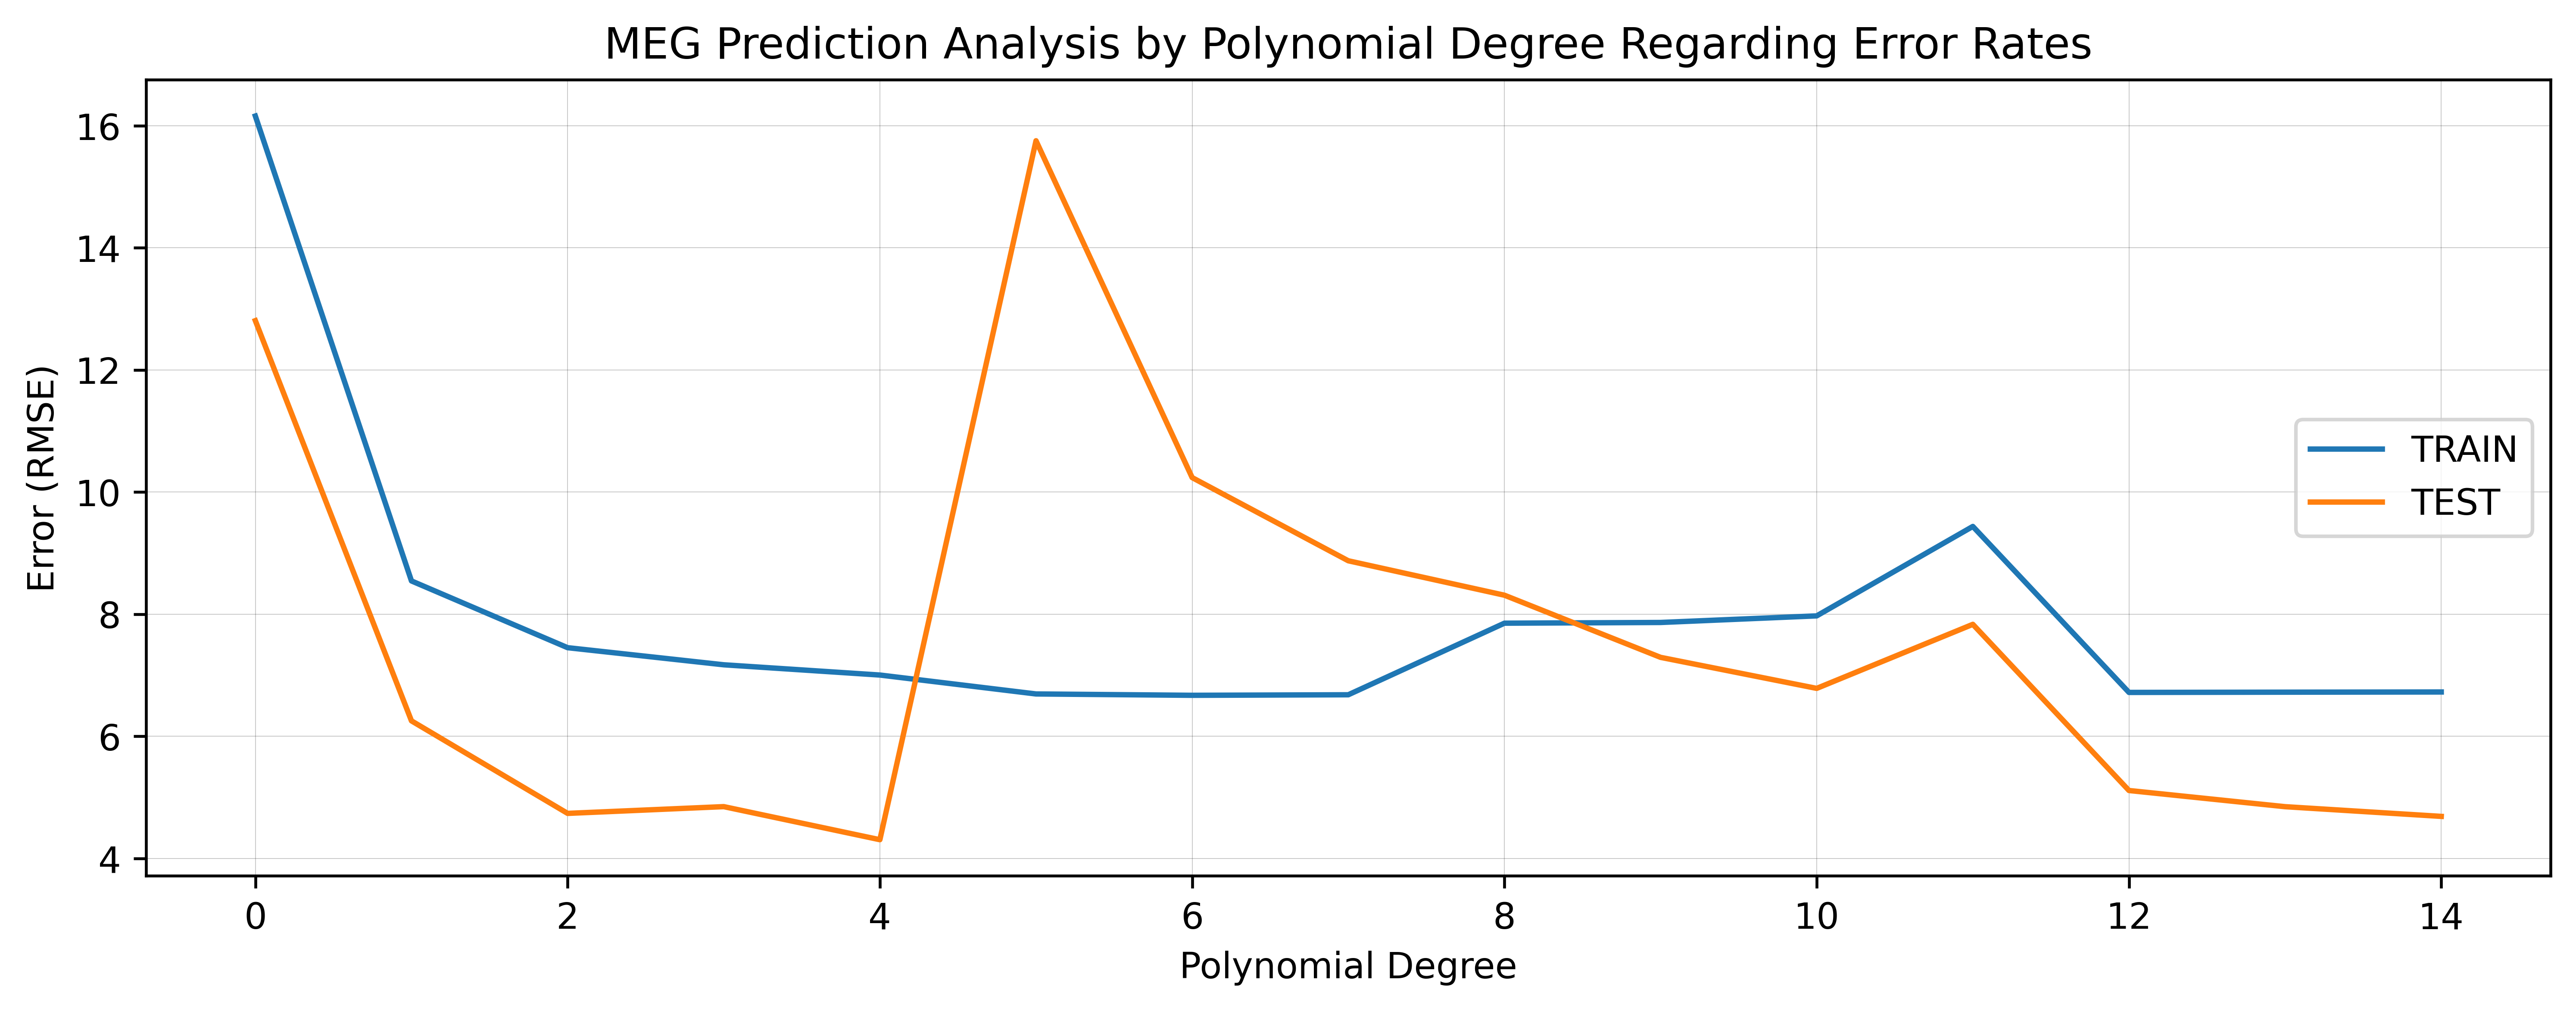

In [21]:
train_rmse_errors = []
test_rmse_errors = []

for d in range(0,15):
    
    polynomial_converter = PolynomialFeatures(degree=d,include_bias=True)
    poly_features = polynomial_converter.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=101)
    
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train,y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_RMSE = np.sqrt(mean_squared_error(y_train,train_pred))
    test_RMSE = np.sqrt(mean_squared_error(y_test,test_pred))
    
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)




plt.figure(figsize=(12,4))

plt.plot(range(0,len(train_rmse_errors)),train_rmse_errors[:],label='TRAIN')
plt.plot(range(0,len(test_rmse_errors)),test_rmse_errors[:],label='TEST')

plt.rcParams['figure.dpi'] = 600

plt.grid(color='black', linestyle='-', linewidth=0.05)

plt.xlabel("Polynomial Degree")
plt.ylabel("Error (RMSE)")

plt.legend(loc="center right", fontsize=10)

plt.title("MEG Prediction Analysis by Polynomial Degree Regarding Error Rates")

In [22]:
final_poly_converter = PolynomialFeatures(degree=3, include_bias=True)

final_model = LinearRegression()

fully_converted_X = final_poly_converter.fit_transform(X)
final_model.fit(fully_converted_X,y)


from joblib import dump, load

dump(final_model, 'EO_MEG_model.joblib')
dump(final_poly_converter, 'EO_MEG_converter.joblib')

loaded_converter_MEG = load('EO_MEG_converter.joblib')
loaded_model_MEG = load('EO_MEG_model.joblib')



def EO_MEG(EO, Water):
    
    loaded_data_MEG = [np.array([EO, Water])]
    
    transformed_data_MEG = loaded_converter_MEG.fit_transform(loaded_data_MEG)
    
    result_MEG = loaded_model_MEG.predict(transformed_data_MEG)
    
    return result_MEG[0][0]

# DEG PRODUCTION

In [23]:
X = df[["MEG(FQ581)"]]
X = X[5:]

y = df[["DEG(FQ582)"]]
y = y[5:]

polynomial_converter = PolynomialFeatures(degree=1 ,include_bias=False)

poly_features = polynomial_converter.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=101)

from sklearn.metrics import mean_absolute_error, mean_squared_error

MSE = mean_squared_error(y_test, MEG_test_predictions)
RMSE = np.sqrt(MSE)


display(RMSE)


247.74795434436868

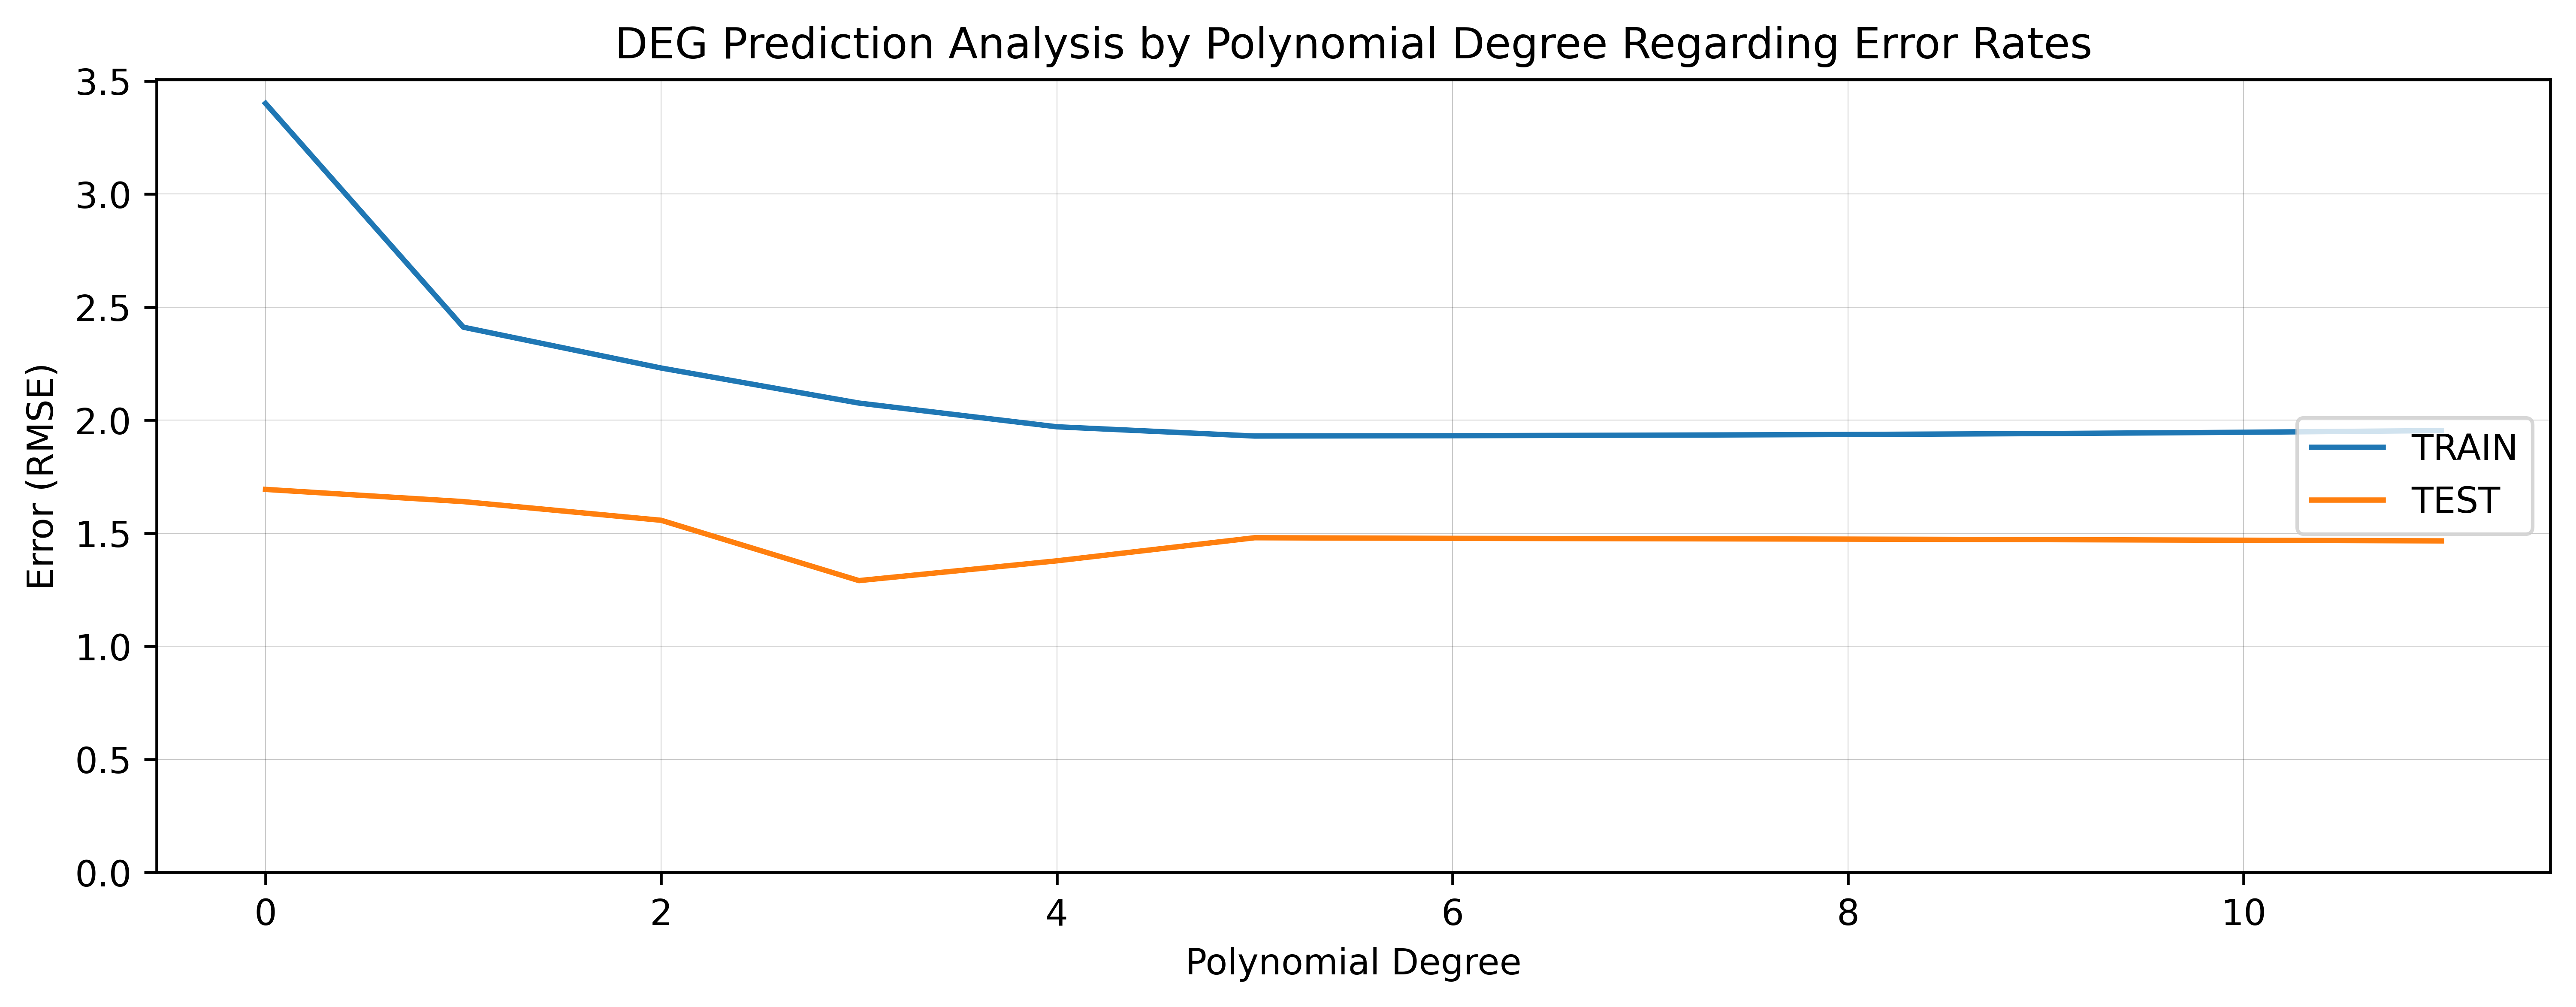

In [24]:
train_rmse_errors = []
test_rmse_errors = []

for d in range(0,12):
    
    polynomial_converter = PolynomialFeatures(degree=d,include_bias=True)
    poly_features = polynomial_converter.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=101)
    
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train,y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_RMSE = np.sqrt(mean_squared_error(y_train,train_pred))
    test_RMSE = np.sqrt(mean_squared_error(y_test,test_pred))
    
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)




plt.figure(figsize=(12,4))

plt.plot(range(0,len(train_rmse_errors)),train_rmse_errors[:],label='TRAIN')
plt.plot(range(0,len(test_rmse_errors)),test_rmse_errors[:],label='TEST')

plt.rcParams['figure.dpi'] = 600

plt.grid(color='black', linestyle='-', linewidth=0.05)

plt.xlabel("Polynomial Degree")
plt.ylabel("Error (RMSE)")

plt.legend(loc="center right", fontsize=10)

plt.title("DEG Prediction Analysis by Polynomial Degree Regarding Error Rates")

plt.ylim(0)

plt.grid(color='black', linestyle='-', linewidth=0.05)

In [25]:
final_poly_converter = PolynomialFeatures(degree=5, include_bias=True)

final_model = LinearRegression()

fully_converted_X = final_poly_converter.fit_transform(X)
final_model.fit(fully_converted_X,y)


from joblib import dump, load

dump(final_model, 'EO_DEG_model.joblib')
dump(final_poly_converter, 'EO_DEG_converter.joblib')

loaded_converter_DEG = load('EO_DEG_converter.joblib')
loaded_model_DEG = load('EO_DEG_model.joblib')



def MEG_DEG(MEG):
    
    loaded_data_DEG = [np.array([MEG])]
    
    transformed_data_DEG = loaded_converter_DEG.fit_transform(loaded_data_DEG)
    
    result_DEG = loaded_model_DEG.predict(transformed_data_DEG)
    
    return result_DEG[0][0]

# PREDICTIONS

In [26]:
def product_prediction(Ethylene, Oxygen, Selectivity):
    
    Water = Ethylene/28.05 * (100 - Selectivity )/100 * 2 * 18.01528 #molar balance
    
    EO_production = EO_prod(Ethylene, Oxygen, Selectivity)
    
    MEG_production = EO_MEG(EO_production, Water)
    
    DEG_production = MEG_DEG(MEG_production)
    
    return EO_production, MEG_production, DEG_production


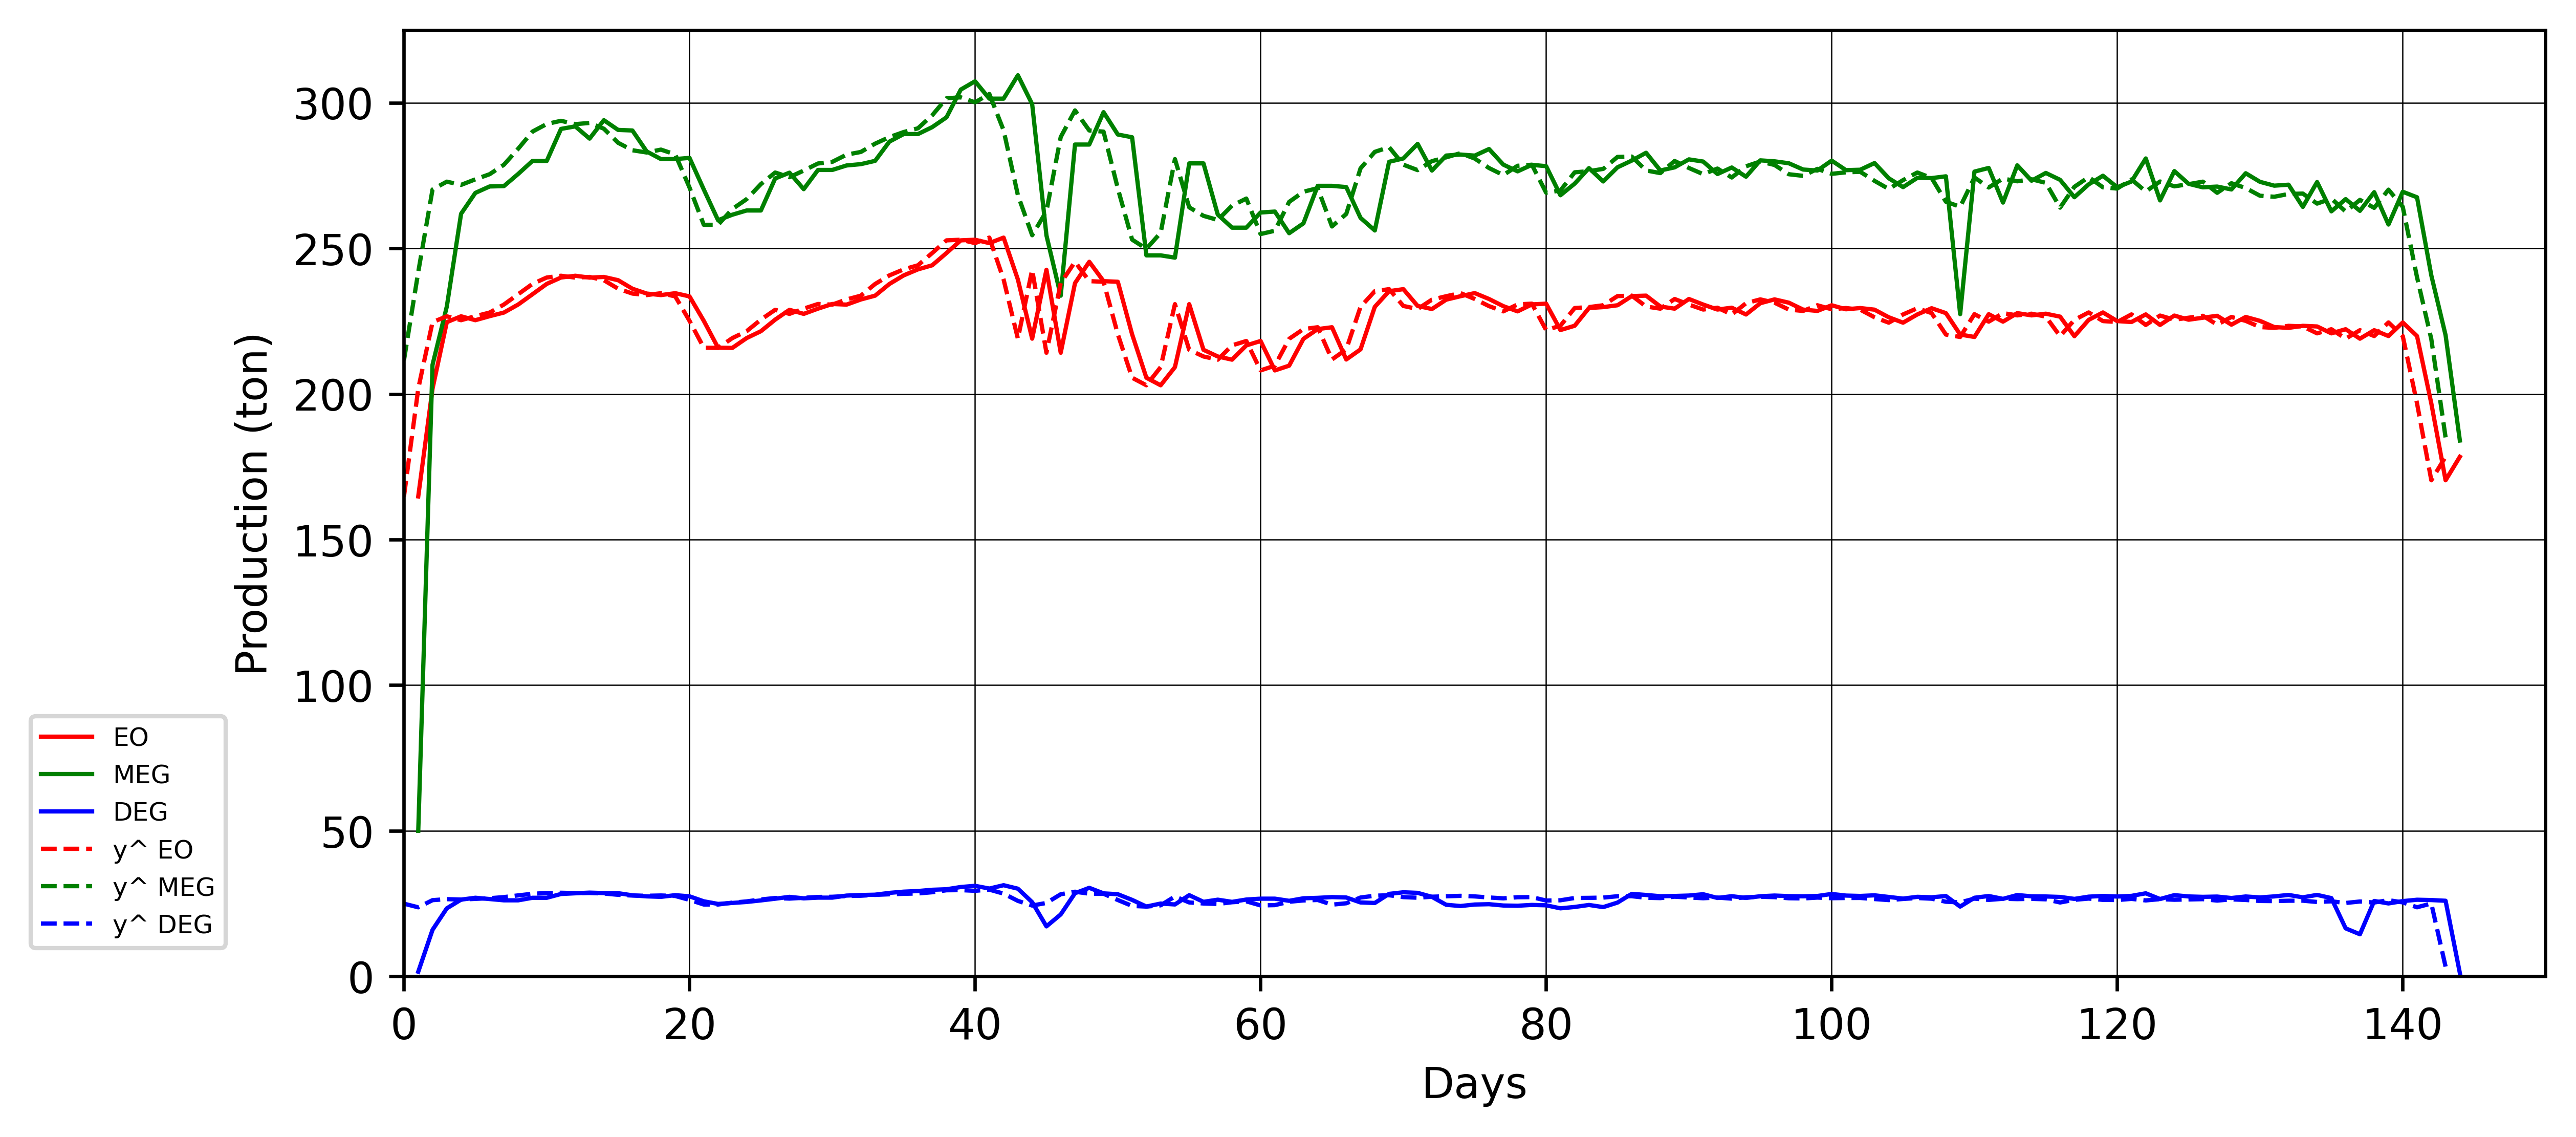

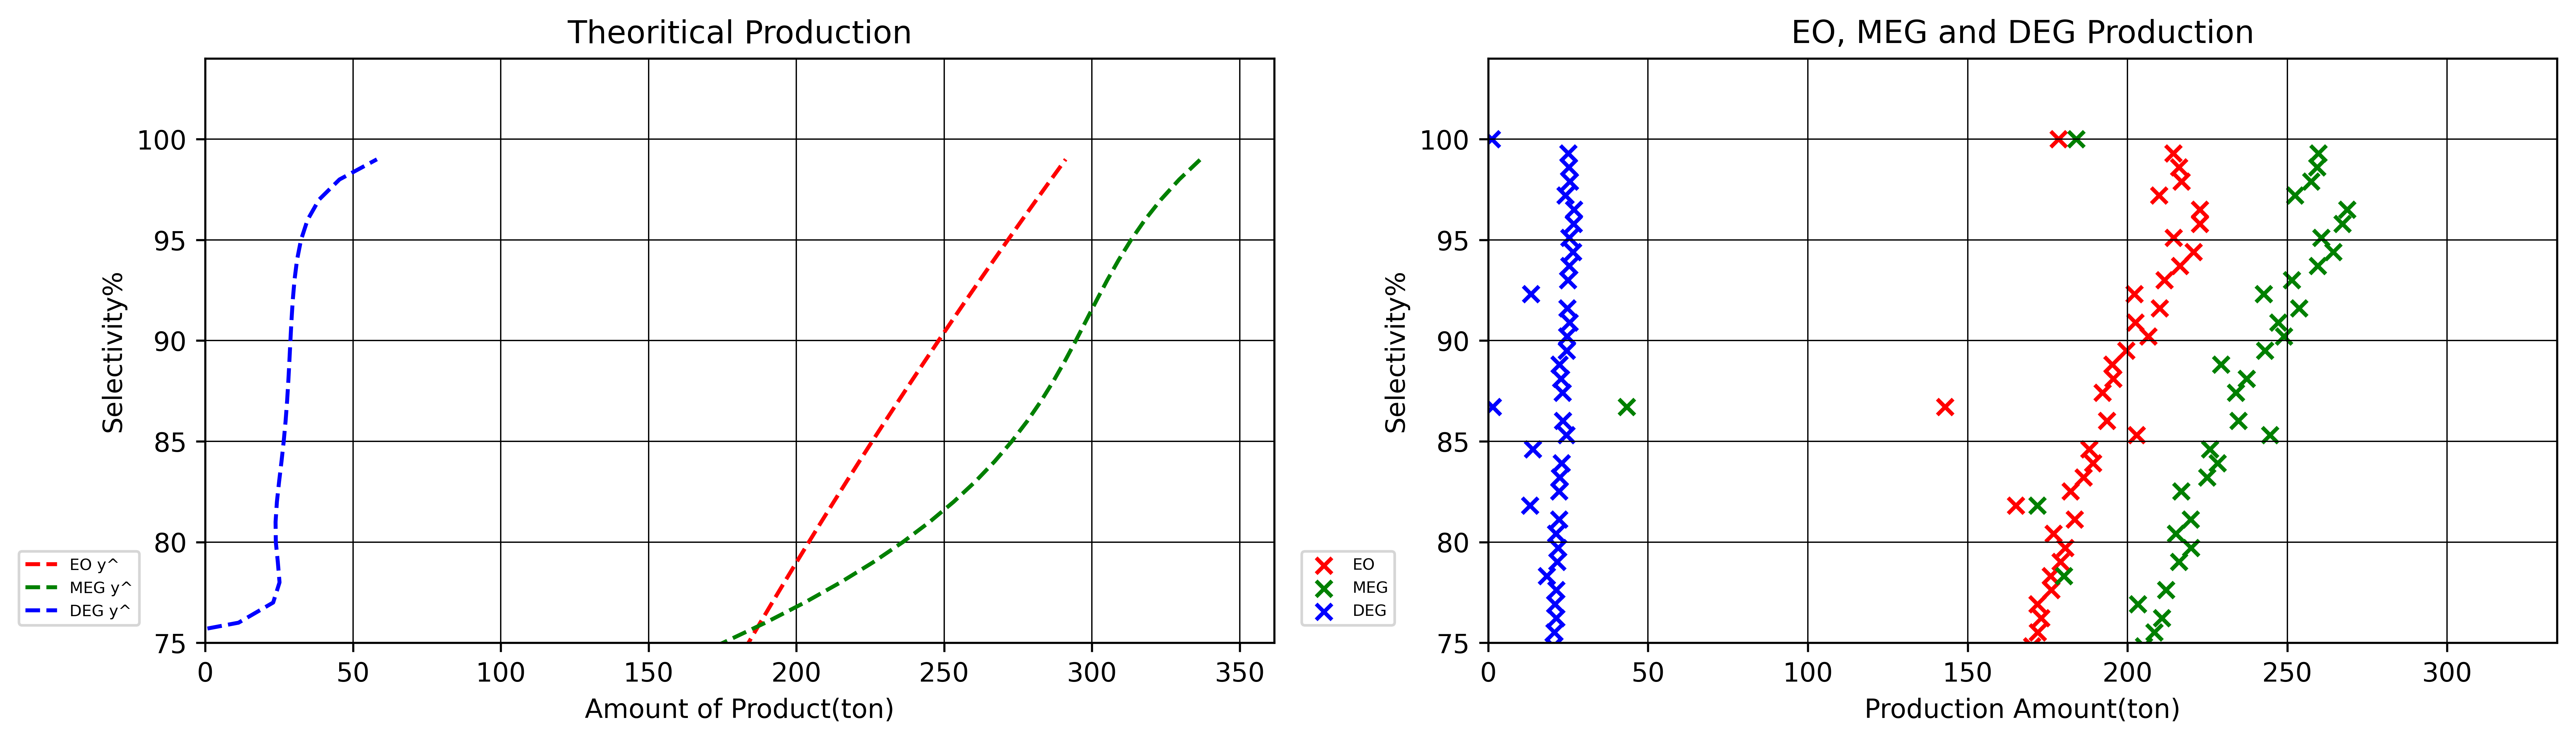

In [27]:
plt.figure(figsize=(9,4))
plt.plot(df["EO Üretim(ton)"], label="EO", color="red",linewidth=1)
plt.plot(df["MEG(FQ581)"], label="MEG", color="green",linewidth=1)
plt.plot(df["DEG(FQ582)"], label="DEG", color="blue",linewidth=1)

EO =[]
MEG=[]
DEG=[]

for row in range(0, len(df)):

    EO += [product_prediction(df["Etilen"].iloc[row], df["Oksijen(ton)"].iloc[row], df["Selektivite"].iloc[row])[0]]
    MEG += [product_prediction(df["Etilen"].iloc[row], df["Oksijen(ton)"].iloc[row], df["Selektivite"].iloc[row])[1]]
    DEG += [product_prediction(df["Etilen"].iloc[row], df["Oksijen(ton)"].iloc[row], df["Selektivite"].iloc[row])[2]]

plt.plot(EO, label="y^ EO",color="red", linestyle='--',linewidth=1, alpha=1)
plt.plot(MEG, label="y^ MEG",color="green", linestyle='--',linewidth=1,alpha=1)
plt.plot(DEG, label="y^ DEG",color="blue", linestyle='--',linewidth=1,alpha=1)

plt.legend(loc=(-0.1743,0.03), fontsize=6)
plt.xlim(0,len(df)+6)
plt.ylim(0)
plt.xlabel("Days")
plt.ylabel("Production (ton)")
plt.grid(color='black', linestyle='-', linewidth=0.3)

def plot_selectivity(Etilen, Oksijen):
    
    eo = []
    meg = []
    deg = []
    water = Etilen/28.05 * (100 - 83.53544)/100 * 2 * 18.01528
    
    for i in range(0, 100):
        
        EO_üretim = EO_prod(Etilen, Oksijen, i)
        eo.append(EO_üretim)
        
        MEG_üretim = EO_MEG(EO_üretim, water)
        meg.append(MEG_üretim)

        DEG_üretim = MEG_DEG(MEG_üretim)
        deg.append(DEG_üretim)
    
    eo  =   np.array(eo)
    meg =   np.array(meg)
    deg =   np.array(deg)
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].plot(eo, range(0, 100), label="EO y^", color="red", linestyle="dashed")
    axes[0].plot(meg, range(0, 100), label="MEG y^", color="green", linestyle="dashed")
    axes[0].plot(deg, range(0, 100), label="DEG y^", color="blue", linestyle="dashed")
    axes[0].legend(loc="lower right", fontsize=10)
    axes[0].set_xlim(0,meg.max()+25)
    axes[0].set_ylim(75,104)
    axes[0].set_title("Theoritical Production")
    axes[0].set_ylabel("Selectivity%")
    axes[0].set_xlabel("Amount of Product(ton)")
    axes[0].grid(color='black', linestyle='-', linewidth=0.5)
    axes[0].figure.set_size_inches(16, 4) 
    axes[0].legend(loc=(-0.1743,0.03), fontsize=6)
    
    df.sort_values(by="Selektivite",ascending=False, inplace=True)
    
    axes[1].scatter((df["EO Üretim(ton)"]*np.linspace(0,100,144)/100), np.linspace(0,100,144), label="EO", color="red",marker="x")
    axes[1].scatter(df["MEG(FQ581)"]*np.linspace(0,100,144)/100, np.linspace(0,100,144), label="MEG", color="green",marker="x")
    axes[1].scatter(df["DEG(FQ582)"]*np.linspace(0,100,144)/100, np.linspace(0,100,144), label="DEG", color="blue",marker="x")
    axes[1].legend(loc="lower right", fontsize=10)
    axes[1].set_xlim(0,df["MEG(FQ581)"].max()+25)
    axes[1].set_ylim(75,104)
    axes[1].set_title("EO, MEG and DEG Production")
    axes[1].set_ylabel("Selectivity%")
    axes[1].set_xlabel("Production Amount(ton)")
    axes[1].grid(color='black', linestyle='-', linewidth=0.5)
    axes[1].figure.set_size_inches(16, 4) 
    axes[1].legend(loc=(-0.1743,0.03), fontsize=6)
    

plot_selectivity(df["Etilen"].mean(), df["Oksijen(ton)"].mean())

